In [26]:
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import numpy as np

from sklearn.metrics import classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Dense,
    Flatten,
    Conv2D,
    MaxPooling2D,
    Dropout,
    BatchNormalization,
    Input,
    RandomFlip,
    RandomBrightness,
    RandomContrast,
    Rescaling,
    RandomRotation,
    RandomZoom
)
from tensorflow.keras.metrics import BinaryAccuracy
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

In [46]:
seed = 1000
batch_size = 8
img_size=224

In [47]:
plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=18,
    titlepad=10,
)
plt.rc("image", cmap="magma")

# Dataset

Divisão em 80% treino, 10% validação e 10% teste


In [48]:
train_ds = image_dataset_from_directory(
    directory="./dataset",
    labels="inferred",
    label_mode="binary",
    color_mode="rgb",
    shuffle=True,
    subset="training",
    seed=seed,
    pad_to_aspect_ratio=False,
    validation_split=0.2, 
    image_size=(img_size, img_size),
    batch_size=batch_size
)

val_test_ds = image_dataset_from_directory(
    directory="./dataset",
    labels="inferred",
    label_mode="binary",
    color_mode="rgb",
    shuffle=True,
    subset="validation",
    seed=seed,
    pad_to_aspect_ratio=False,
    validation_split=0.2, 
    image_size=(img_size, img_size),
    batch_size=batch_size
)

val_batches = tf.data.experimental.cardinality(val_test_ds)
test_ds = val_test_ds.take(val_batches // 2)
val_ds = val_test_ds.skip(val_batches // 2)

print(f"Número de lotes no conjunto de treino: {tf.data.experimental.cardinality(train_ds)}")
print(f"Número de lotes no conjunto de validação: {tf.data.experimental.cardinality(val_ds)}")
print(f"Número de lotes no conjunto de teste: {tf.data.experimental.cardinality(test_ds)}")

Found 923 files belonging to 2 classes.
Using 739 files for training.
Found 923 files belonging to 2 classes.
Using 184 files for validation.
Número de lotes no conjunto de treino: 93
Número de lotes no conjunto de validação: 12
Número de lotes no conjunto de teste: 11


In [49]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Modelo


In [50]:
data_augmentation = Sequential([
	RandomFlip(mode="horizontal", seed=seed),
	RandomBrightness(factor=0.2, seed=seed),
	RandomContrast(factor=0.2, seed=seed)
])

In [54]:
model = Sequential([
    Input(shape=(img_size, img_size, 3)),
	data_augmentation,
 	Rescaling(1./255),
    Conv2D(filters=32, kernel_size=(3, 3), activation="relu", kernel_initializer="he_normal", padding="same"),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(filters=64, kernel_size=(3, 3), activation="relu", kernel_initializer="he_normal", padding="same"),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(filters=128, kernel_size=(3, 3), activation="relu", kernel_initializer="he_normal", padding="same"),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(filters=256, kernel_size=(3, 3), activation="relu", kernel_initializer="he_normal", padding="same"),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(filters=512, kernel_size=(3, 3), activation="relu", kernel_initializer="he_normal", padding="same"),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(units=512, activation="relu", kernel_initializer="he_normal"),
    Dropout(0.2),
    Dense(units=256, activation="relu", kernel_initializer="he_normal"),
    Dropout(0.2),
    Dense(units=128, activation="relu", kernel_initializer="he_normal"),
    Dense(units=1, activation="sigmoid")
])

model.compile(
    optimizer="adam", loss="binary_crossentropy", metrics=[BinaryAccuracy()]
)

# model.summary()

CallBacks


In [55]:
es = EarlyStopping(
    monitor="val_binary_accuracy", patience=40, restore_best_weights=True, verbose=True
)

rlr = ReduceLROnPlateau(monitor="val_binary_accuracy", factor=0.2, patience=30, verbose=True)

cp = ModelCheckpoint(
    f"./checkpoint/cnn-8/test-size-{batch_size}/checkpoint.model.keras",
    monitor="val_binary_accuracy",
    save_best_only=True,
    mode="max",
    verbose=True,
)

In [56]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=300,
    callbacks=[es, rlr, cp],
)

Epoch 1/300
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step - binary_accuracy: 0.5551 - loss: 7.1020
Epoch 1: val_binary_accuracy improved from -inf to 0.47917, saving model to ./checkpoint/cnn-8/test-size-8/checkpoint.model.keras
93/93 ━━━━━━━━━━━━━━━━━━━━ 31s 294ms/step - binary_accuracy: 0.5554 - loss: 7.1012 - val_binary_accuracy: 0.4792 - val_loss: 24.4795 - learning_rate: 0.0010
Epoch 2/300
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step - binary_accuracy: 0.5863 - loss: 4.9748
Epoch 2: val_binary_accuracy improved from 0.47917 to 0.50000, saving model to ./checkpoint/cnn-8/test-size-8/checkpoint.model.keras
93/93 ━━━━━━━━━━━━━━━━━━━━ 26s 276ms/step - binary_accuracy: 0.5867 - loss: 4.9685 - val_binary_accuracy: 0.5000 - val_loss: 8.0131 - learning_rate: 0.0010
Epoch 3/300
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step - binary_accuracy: 0.6130 - loss: 3.5325
Epoch 3: val_binary_accuracy improved from 0.50000 to 0.53125, saving model to ./checkpoint/cnn-8/test-size-8/checkpoint.model.keras
93/93 ━━━

# Resultados


In [57]:
y_pred = model.predict(test_ds, batch_size=batch_size, verbose=1)
y_pred_bool = (y_pred > 0.5).astype(int)

y_test = np.concatenate([y for x, y in test_ds], axis=0)

print(classification_report(y_test, y_pred_bool))

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step
              precision    recall  f1-score   support

         0.0       0.53      0.61      0.57        44
         1.0       0.54      0.45      0.49        44

    accuracy                           0.53        88
   macro avg       0.53      0.53      0.53        88
weighted avg       0.53      0.53      0.53        88



<Axes: >

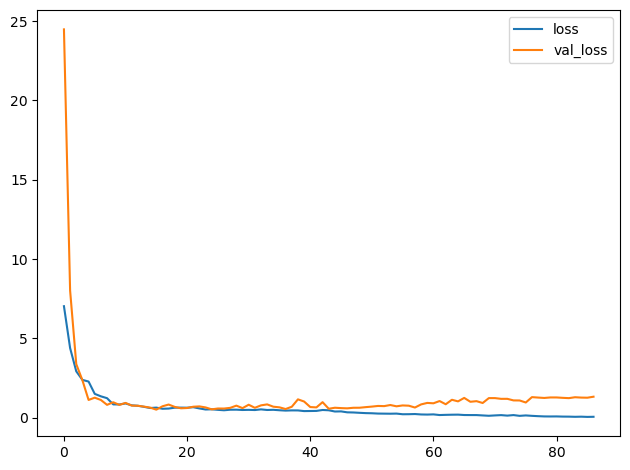

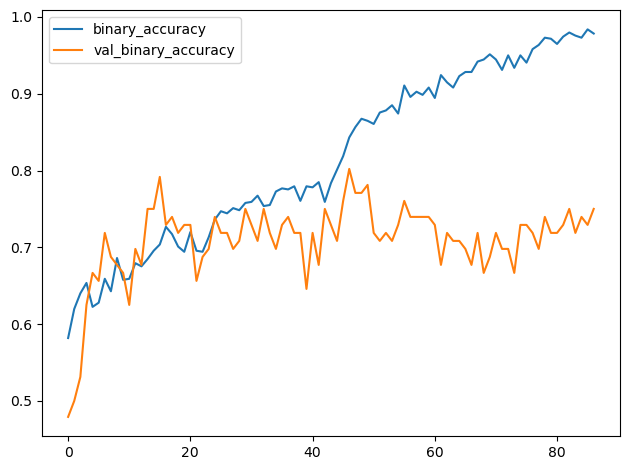

In [58]:
history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ["loss", "val_loss"]].plot()
history_frame.loc[:, ["binary_accuracy", "val_binary_accuracy"]].plot()